# Data Overview


In [23]:
import pandas as pd

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

print(rental_price_data.head())
print(rating_features_data.head())

print(rental_price_data.describe())
print(rating_features_data.describe())

     price
0  $300.00
1   $99.00
2  $100.00
3  $100.00
4  $599.00
   accommodates                                          amenities  \
0             6  {"Cable TV",Internet,"Wireless Internet","Air ...   
1             2  {"Air Conditioning",Heating,"Family/Kid Friend...   
2             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...   
4             6  {TV,"Cable TV",Internet,"Wireless Internet","A...   

   availability_30  bathrooms  bed_type  bedrooms  beds  \
0                0        2.5  Real Bed       1.0   3.0   
1               29        0.0     Futon       1.0   1.0   
2               30        1.5  Real Bed       1.0   1.0   
3               30        1.5  Real Bed       1.0   1.0   
4               27        2.0  Real Bed       3.0   3.0   

   calculated_host_listings_count cancellation_policy  guests_included  \
0                               1            moderate                1   
1         

# Nature of the Data

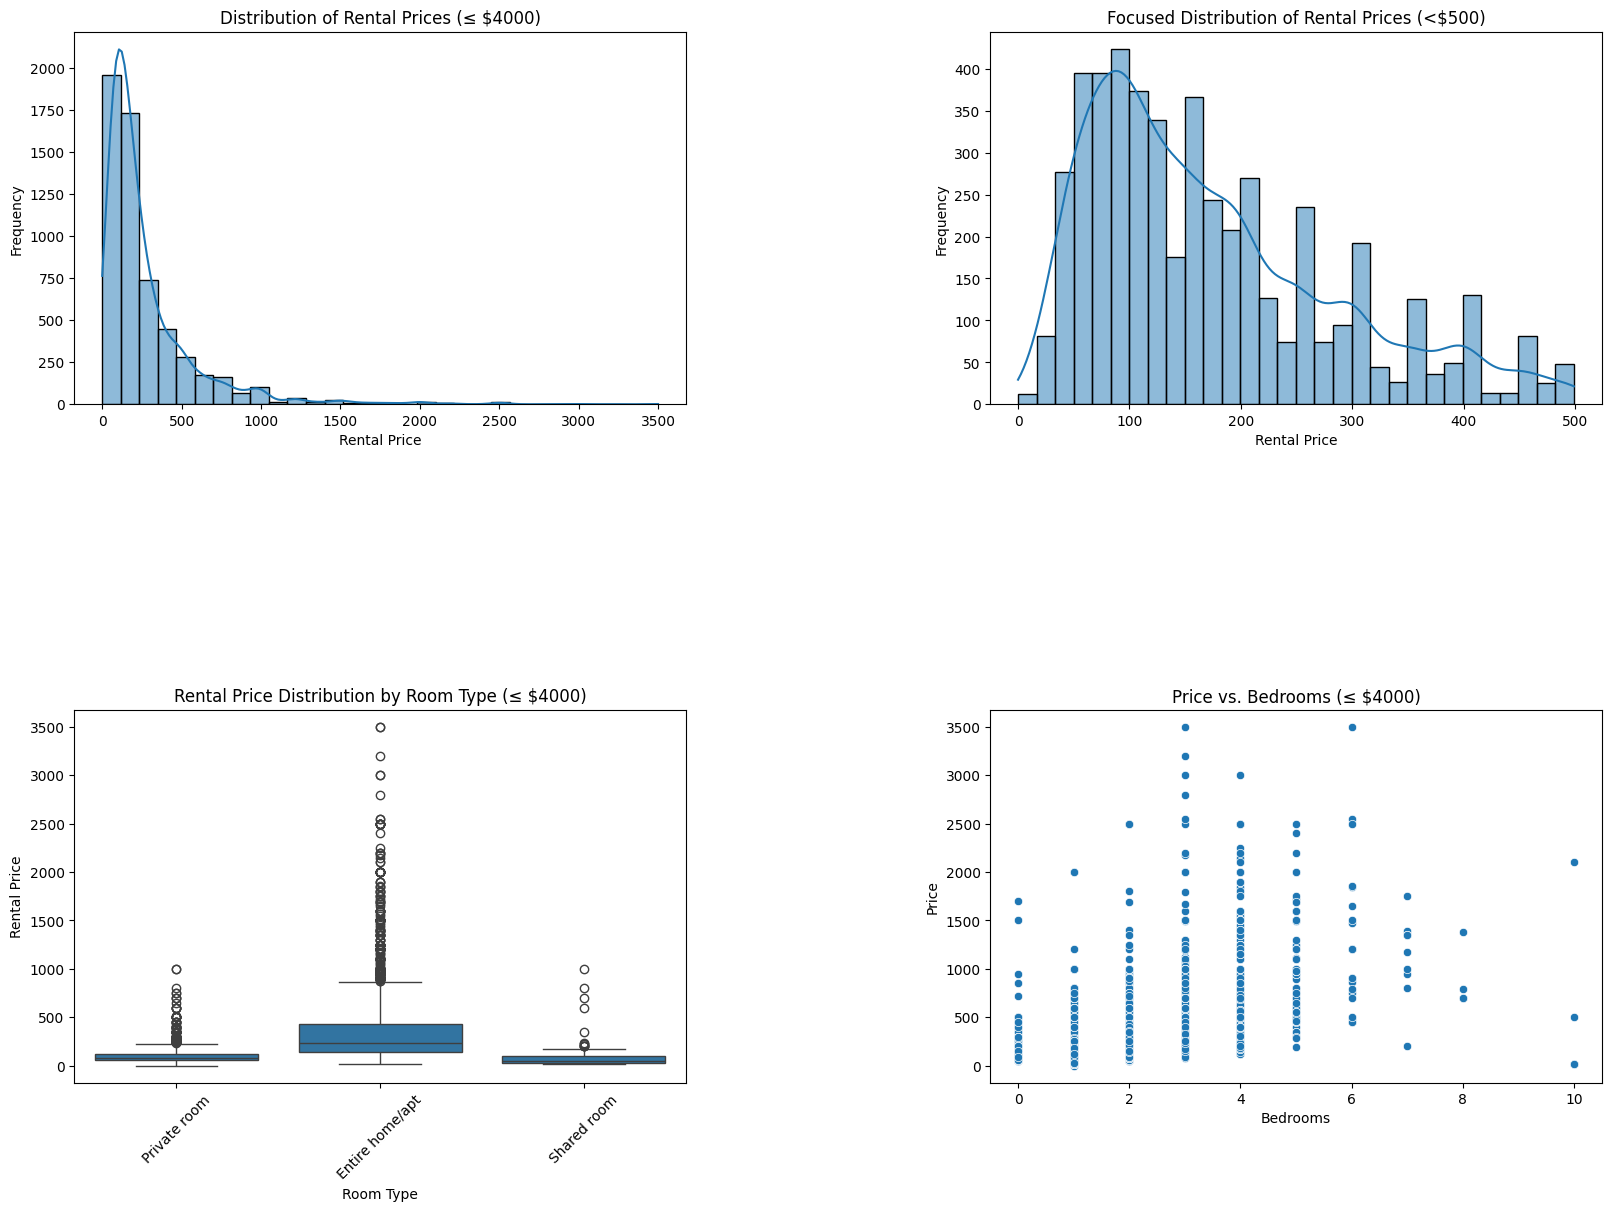

Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_df = pd.concat([rating_features_data, rental_price_data['price']], axis=1)

# Ensure 'price' is converted to numeric (float)
merged_df['price'] = pd.to_numeric(merged_df['price'].replace('[\$,]', '', regex=True), errors='coerce')

# Drop any rows where 'price' could not be converted and ended up as NaN
merged_df = merged_df.dropna(subset=['price'])

# Set up the figure for a 2x2 grid of plots with increased spacing and use constrained layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3}, constrained_layout=True)

# Histogram of Rental Prices (excluding prices above $4000)
filtered_prices = merged_df[merged_df['price'] <= 4000]['price']
sns.histplot(filtered_prices, bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Rental Prices (≤ $4000)')
axes[0, 0].set_xlabel('Rental Price')
axes[0, 0].set_ylabel('Frequency')

# Focused Histogram of Rental Prices in a Main Area (e.g., prices below a threshold)
sns.histplot(merged_df[merged_df['price'] < 500]['price'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Focused Distribution of Rental Prices (<$500)')
axes[0, 1].set_xlabel('Rental Price')
axes[0, 1].set_ylabel('Frequency')

# Boxplot of Prices by Room Type (excluding prices above $4000)
sns.boxplot(x='room_type', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 0])
axes[1, 0].set_title('Rental Price Distribution by Room Type (≤ $4000)')
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Rental Price')
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter Plot of Price vs. Bedrooms (excluding prices above $4000)
sns.scatterplot(x='bedrooms', y='price', data=merged_df[merged_df['price'] <= 4000], ax=axes[1, 1])
axes[1, 1].set_title('Price vs. Bedrooms (≤ $4000)')
axes[1, 1].set_xlabel('Bedrooms')
axes[1, 1].set_ylabel('Price')

# Adjust layout
plt.show()

# Note about excluded prices
print("Note: Rental prices above $4000 have been excluded from the visualizations to allow for better display.")

# Preprocessing

- we only look at key ameniteis based on their frequency in the data set and perosonal obsrvation on most important amenities.

### Missing Values
- for missing values bathrooms, beds, review_scores_checkin, review_scores_communication, review_scores_location,
review_scores_rating, review_scores_value mean was assesed. 
- for is host_is_superhost flase is assumed
- for host_listings_count 1 is assuemed. Therefor it is assumed that the host only has one listing.

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
rental_price_data = pd.read_csv('../data/rental_price.csv')
rating_features_data = pd.read_csv('../data/rating_features.csv')

# Function to extract key amenities directly from the amenities string
def extract_key_amenities_directly(amenities):
    key_amenities = ['Internet', 'Wireless Internet', 'Kitchen', 'Heating', 'Essentials', 'TV',
                     'Washer', 'Dryer', 'Free parking on premises', 'Air conditioning', 'Breakfast',
                     'Pets allowed', 'Family/kid friendly', 'Suitable for events']
    # Normalize the amenities string for consistent matching
    amenities = amenities.lower().replace('"', '').replace('{', '').replace('}', '').replace(' ', '')
    features = {amenity: 1 if amenity.lower().replace(' ', '') in amenities else 0 for amenity in key_amenities}
    return pd.Series(features)

# Apply the function to extract key amenities and add them as new columns
key_amenities_df = rating_features_data['amenities'].apply(extract_key_amenities_directly)
rating_features_data = pd.concat([rating_features_data, key_amenities_df], axis=1)

# Optionally drop the original 'amenities' column if no longer needed
rating_features_data.drop('amenities', axis=1, inplace=True)

# Convert price from string to float
rental_price_data['price'] = rental_price_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values
print("Before Preproccessing")
print("Missing values in rental data:", rental_price_data.isnull().sum())
print("Missing values in rating features data:", rating_features_data.isnull().sum())

# Fill missing values in 'host_is_superhost' with False
rating_features_data['host_is_superhost'].fillna('f', inplace=True)

# Fill missing values in 'host_listings_count' with 1
rating_features_data['host_listings_count'].fillna(1, inplace=True)


# Fill missing values for numerical columns with the median
for column in rating_features_data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = rating_features_data[column].median()
    rating_features_data[column].fillna(median_value, inplace=True)
    
#Scale Nummerical Values with MinMaxScaler
scaler = MinMaxScaler()
numerical_columns = rating_features_data.select_dtypes(include=['float64', 'int64']).columns
rating_features_data[numerical_columns] = scaler.fit_transform(rating_features_data[numerical_columns])

# Has availabiltiy is allways true. Therefor it can be droped
rating_features_data.drop('has_availability',axis=1, inplace=True)

#Replace t and f with True and False
mapping = {'f': 0, 't': 1}
rating_features_data['host_is_superhost'] = rating_features_data['host_is_superhost'].map(mapping)
rating_features_data['instant_bookable'] = rating_features_data['instant_bookable'].map(mapping)

# Encode categorical variables using one-hot encoding
categorical_columns = ['room_type', 'bed_type', 'property_type', 'cancellation_policy']
rating_features_data = pd.get_dummies(rating_features_data, columns=categorical_columns)

#Convert all Data to numerical data
rating_features_data = rating_features_data.astype(float)

pd.set_option('display.max_columns', None)

# Convert to DataFrame and use to_string to display all columns
rental_missing = rental_price_data.isnull().sum().reset_index()
rating_missing = rating_features_data.isnull().sum().reset_index()

# Print to check if there are still missing values
print("\nMissing values in rental data:\n", rental_missing.to_string(index=False, header=['Column', 'Missing Values']))
print("Missing values in rating features data:\n", rating_missing.to_string(index=False, header=['Column', 'Missing Values']))


Before Preproccessing
Missing values in rental data: price    0
dtype: int64
Missing values in rating features data: accommodates                         0
availability_30                      0
bathrooms                           46
bed_type                             0
bedrooms                             6
beds                                23
calculated_host_listings_count       0
cancellation_policy                  0
guests_included                      0
has_availability                     0
host_is_superhost                   15
host_listings_count                 15
instant_bookable                     0
latitude(North)                      0
longitude(East)                      0
maximum_nights                       0
number_of_reviews                    0
property_type                        0
review_scores_checkin             2057
review_scores_communication       2057
review_scores_location            2056
review_scores_rating              2046
review_scores_value      

In [26]:
import pandas as pd

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

# Detect outliers in 'price'
price_outliers = detect_outliers_iqr(rental_price_data, 'price')
print("\nOutliers detected based on price:\n", price_outliers.sum())

#Outlier Removal
rental_price_data = rental_price_data[~price_outliers]
rating_features_data = rating_features_data.loc[rental_price_data.index]

# Print the datasets after removing outliers
print("\nData after outlier removal based on price:")
print(rental_price_data.describe())
print(rating_features_data.describe())


Outliers detected based on price:
 392

Data after outlier removal based on price:
             price
count  5442.000000
mean    211.327821
std     164.683574
min       0.000000
25%      90.000000
50%     150.000000
75%     288.000000
max     785.000000
       accommodates  availability_30    bathrooms     bedrooms         beds  \
count   5442.000000      5442.000000  5442.000000  5442.000000  5442.000000   
mean       0.208355         0.546650     0.172627     0.160842     0.069815   
std        0.163650         0.407600     0.078853     0.099720     0.095001   
min        0.000000         0.000000     0.000000     0.000000     0.000000   
25%        0.066667         0.033333     0.125000     0.100000     0.000000   
50%        0.200000         0.633333     0.125000     0.100000     0.066667   
75%        0.333333         0.966667     0.250000     0.200000     0.133333   
max        1.000000         1.000000     1.000000     1.000000     1.000000   

       calculated_host_listings_c

## Merge Data Sets and Definition of X and Y. 
## Train Test split to ensure there is no data leakage.

### This will be used in the rest of the code

In [29]:
from sklearn.model_selection import train_test_split
# Merge the datasets based on a common key
merged_df = pd.concat([rating_features_data, rental_price_data], axis=1)

# Analyze variance explained by each feature
X = merged_df.drop(columns='price')  # Drop rental price
y = merged_df['price']

# Train Test split with stratification
y_binned = pd.qcut(y, q=10, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Correlation Analysis

- Analysis what coloumns have an high impact on rent price.
- Variance Explination Calculation
- Correlation Matrix between the rating features

Correlation with rental price:
price                     1.000000
bedrooms                  0.571092
accommodates              0.535453
bathrooms                 0.522341
beds                      0.460546
                            ...   
Essentials               -0.114739
room_type_Shared room    -0.120856
host_is_superhost        -0.121683
number_of_reviews        -0.185235
room_type_Private room   -0.415652
Name: price, Length: 65, dtype: float64


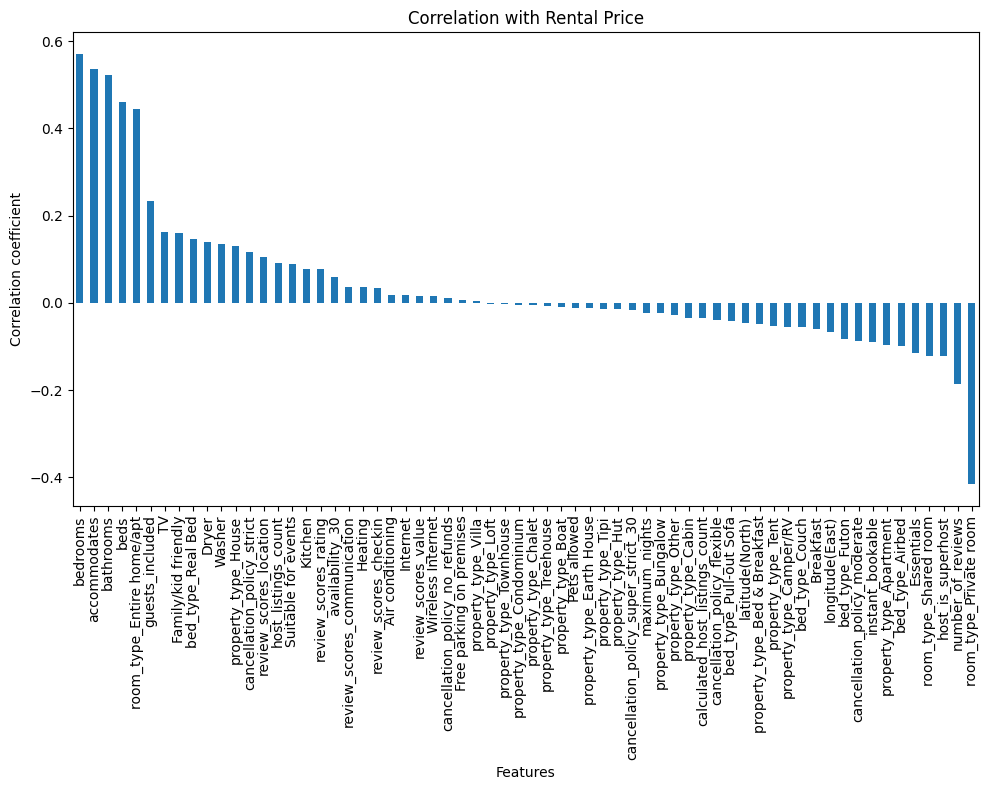

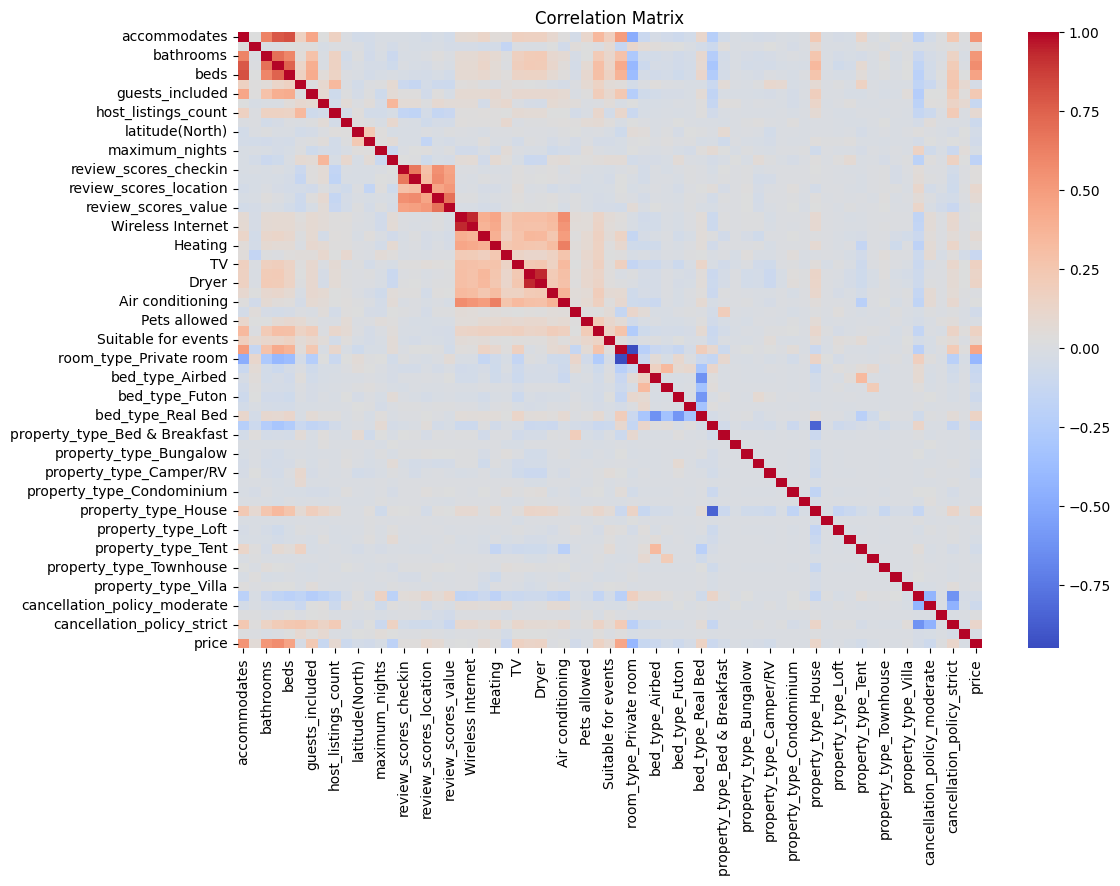

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate the correlation
correlation_matrix = merged_df.corr()
rental_price_correlation = correlation_matrix['price'].sort_values(ascending=False)
pd.set_option('display.max_columns', None)
print("Correlation with rental price:")
print(rental_price_correlation)
plt.figure(figsize=(10, 8))
rental_price_correlation.drop('price').plot(kind='bar')
plt.title('Correlation with Rental Price')
plt.xlabel('Features')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,fmt='2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Model Selection

Deciding what models are the most promising to optimize 


In [11]:
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=25),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regressor': AdaBoostRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
    'Neural Network Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse=np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RSME': rmse }
    print(f"\n{name}: \n Mean Squared Error: {mse}\n Root Mean Squared Error: {rmse},\n R^2 Score: {r2}\n")



Linear Regression: 
 Mean Squared Error: 14079.27398950666
 Root Mean Squared Error: 118.65611652800146,
 R^2 Score: 0.5151091631246698


Ridge Regression: 
 Mean Squared Error: 14084.7923221888
 Root Mean Squared Error: 118.67936771903025,
 R^2 Score: 0.5149191114959855


Elastic Net: 
 Mean Squared Error: 22749.825620837277
 Root Mean Squared Error: 150.83045322758025,
 R^2 Score: 0.21649497038858678


Decision Tree: 
 Mean Squared Error: 22837.935720844813
 Root Mean Squared Error: 151.12225422102733,
 R^2 Score: 0.21346045453488127


Random Forest: 
 Mean Squared Error: 11748.822859412305
 Root Mean Squared Error: 108.39198706275434,
 R^2 Score: 0.5953700060921918


KNN Regressor: 
 Mean Squared Error: 17932.588489990816
 Root Mean Squared Error: 133.91261512639807,
 R^2 Score: 0.38240083638309497


Support Vector Regressor: 
 Mean Squared Error: 25029.944225698484
 Root Mean Squared Error: 158.20854662659184,
 R^2 Score: 0.13796758188047376


Gradient Boosting Regressor: 
 Mean S

The best Models are:

1. Gradient Booster Regressor
2. Random Forest 

## Hyperparmeter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids
param_grid_gbr = {
    'n_estimators': [ 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

param_grid_rf = {
    'n_estimators': [ 300, 400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [ 5, 10, 15]
}

# Initialize the models
gbr = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV for each model
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

# Fit the models
grid_search_gbr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Best parameters and scores
best_gbr = grid_search_gbr.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Predict and evaluate
models = {
    'Gradient Boosting Regressor': best_gbr,
    'Random Forest Regressor': best_rf,
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {'MSE': mse, 'R^2': r2, 'RMSE': rmse}
    print(f"{name} - Mean Squared Error: {mse}, R^2 Score: {r2}, Root Mean Squared Error: {rmse}")

# Print best parameters
print("Best parameters for Gradient Boosting Regressor: ", grid_search_gbr.best_params_)
print("Best parameters for Random Forest Regressor: ", grid_search_rf.best_params_)


Gradient Boosting Regressor - Mean Squared Error: 10592.880870264244, R^2 Score: 0.6351807007995385, Root Mean Squared Error: 102.92172205255916
Random Forest Regressor - Mean Squared Error: 11592.862689270058, R^2 Score: 0.6007412814488513, Root Mean Squared Error: 107.67015691114256
Best parameters for Gradient Boosting Regressor:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400}
Best parameters for Random Forest Regressor:  {'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 500}


## Feature Importance

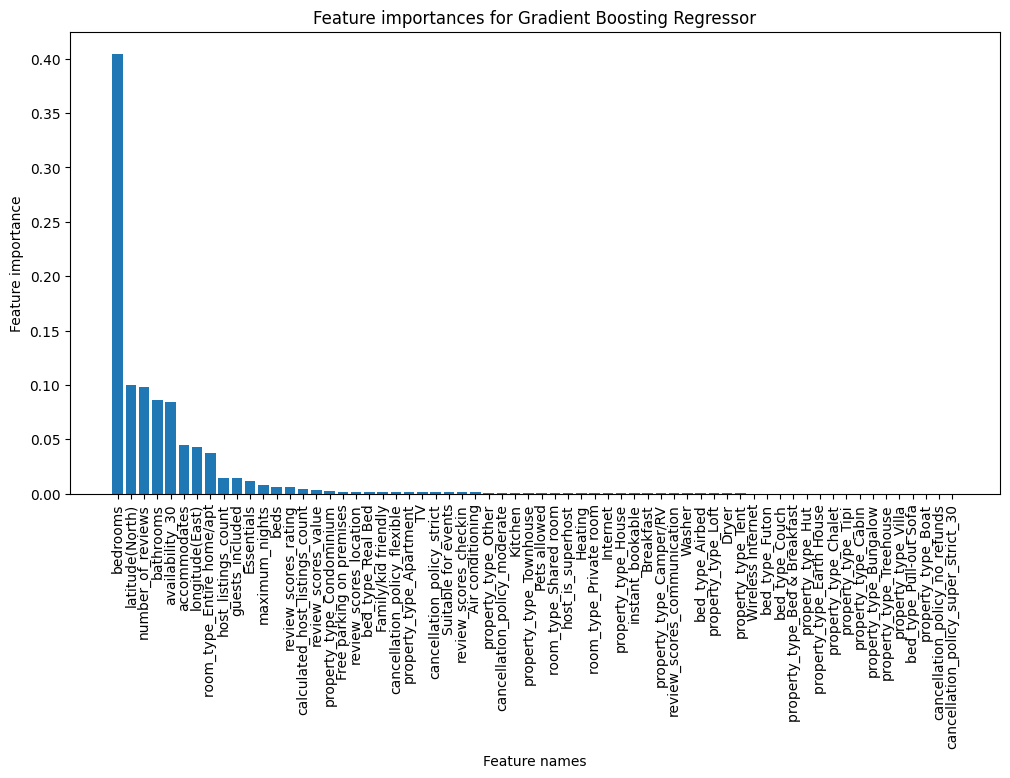

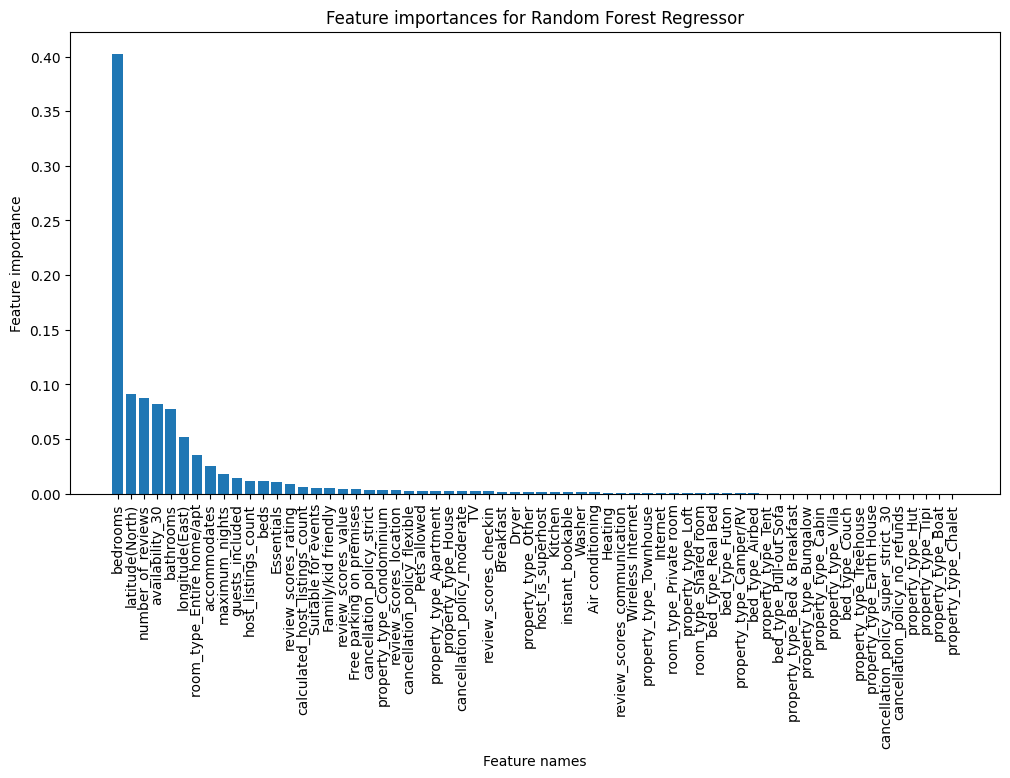

In [13]:
from sklearn.feature_selection import SelectFromModel
import math

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Fit the models to get the feature importances
best_gbr.fit(X_train, y_train)
best_rf.fit(X_train, y_train)

#GBR
# Feature importances for Gradient Boosting Regressor
gbr_feature_importances = best_gbr.feature_importances_
gbr_indices = np.argsort(gbr_feature_importances)[::-1]
sorted_gbr_feature_importances = gbr_feature_importances[gbr_indices]
sorted_gbr_feature_names = [feature_names[i] for i in gbr_indices]
plt.figure(figsize=(12, 6))
plt.bar(sorted_gbr_feature_names, sorted_gbr_feature_importances, align='center')
plt.xlabel('Feature names')
plt.ylabel('Feature importance')
plt.title('Feature importances for Gradient Boosting Regressor')
plt.xticks(rotation=90)
plt.show()

#RF
# Feature importances for Random Forest Regressor
rf_feature_importances = best_rf.feature_importances_
rf_indices = np.argsort(rf_feature_importances)[::-1]
sorted_rf_feature_importances = rf_feature_importances[rf_indices]
sorted_rf_feature_names = [feature_names[i] for i in rf_indices]
plt.figure(figsize=(12, 6))
plt.bar(sorted_rf_feature_names, sorted_rf_feature_importances, align='center')
plt.xlabel('Feature names')
plt.ylabel('Feature importance')
plt.title('Feature importances for Random Forest Regressor')
plt.xticks(rotation=90)
plt.show()

## Model optimisation with important Features

In [14]:
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return r2, mse, rmse

# Initialize dictionaries to store models and their evaluation metrics
gbr_models = {}
rf_models = {}
gbr_metrics = {}
rf_metrics = {}

thresholds = [0.05, 0.01, 0.005]
for threshold in thresholds:
    print(f"\nThreshold: {threshold}")

    best_gbr.fit(X_train, y_train)
    best_rf.fit(X_train, y_train)

    # Gradient Boosting Regressor
    feature_selected_best_gbr = SelectFromModel(best_gbr, threshold=threshold, prefit=True)
    X_train_gbr_selected = feature_selected_best_gbr.transform(X_train)
    X_test_gbr_selected = feature_selected_best_gbr.transform(X_test)
    selected_gbr_features_indices = feature_selected_best_gbr.get_support(indices=True)
    selected_gbr_features = [feature_names[i] for i in selected_gbr_features_indices]
    print("Selected features for Gradient Boosting Regressor:\n", selected_gbr_features)
    
    gbr_clone = best_gbr  # Clone the original model to avoid overwriting
    gbr_clone.fit(X_train_gbr_selected, y_train)
    y_pred_gbr = gbr_clone.predict(X_test_gbr_selected)
    r2_gbr, mse_gbr, rmse_gbr = evaluate_model(y_test, y_pred_gbr)
    print(f"Gradient Boosting Regressor\n   - R²: {r2_gbr:.4f},\n   - MSE: {mse_gbr:.4f},\n   - RMSE: {rmse_gbr:.4f}")
    
    gbr_models[threshold] = gbr_clone
    gbr_metrics[threshold] = {'R²': r2_gbr, 'MSE': mse_gbr, 'RMSE': rmse_gbr}

    # Random Forest Regressor
    feature_selected_best_rf = SelectFromModel(best_rf, threshold=threshold, prefit=True)
    X_train_rf_selected = feature_selected_best_rf.transform(X_train)
    X_test_rf_selected = feature_selected_best_rf.transform(X_test)
    selected_rf_features_indices = feature_selected_best_rf.get_support(indices=True)
    selected_rf_features = [feature_names[i] for i in selected_rf_features_indices]
    print("Selected features for Random Forest Regressor:\n", selected_rf_features)
    
    rf_clone = best_rf  # Clone the original model to avoid overwriting
    rf_clone.fit(X_train_rf_selected, y_train)
    y_pred_rf = rf_clone.predict(X_test_rf_selected)
    r2_rf, mse_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)
    print(f"Random Forest Regressor\n   - R²: {r2_rf:.4f},\n   - MSE: {mse_rf:.4f},\n   - RMSE: {rmse_rf:.4f}")
    
    rf_models[threshold] = rf_clone
    rf_metrics[threshold] = {'R²': r2_rf, 'MSE': mse_rf, 'RMSE': rmse_rf}



Threshold: 0.05
Selected features for Gradient Boosting Regressor:
 ['availability_30', 'bathrooms', 'bedrooms', 'latitude(North)', 'number_of_reviews']
Gradient Boosting Regressor
   - R²: 0.5378,
   - MSE: 13421.6310,
   - RMSE: 115.8518
Selected features for Random Forest Regressor:
 ['availability_30', 'bathrooms', 'bedrooms', 'latitude(North)', 'longitude(East)', 'number_of_reviews']
Random Forest Regressor
   - R²: 0.5437,
   - MSE: 13249.4847,
   - RMSE: 115.1064

Threshold: 0.01
Selected features for Gradient Boosting Regressor:
 ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'guests_included', 'host_listings_count', 'latitude(North)', 'longitude(East)', 'number_of_reviews', 'Essentials', 'room_type_Entire home/apt']
Gradient Boosting Regressor
   - R²: 0.6292,
   - MSE: 10765.3407,
   - RMSE: 103.7562
Selected features for Random Forest Regressor:
 ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'host_listings_count', 'lat

## Model Evaluation

1. The best Model is the Gradient Boosting Regressor Model with all Features
2. The Gradient Boosting Regressor Model with a threshold of 0.01 almost has the same performance but can also be used if data collection is expensive or performance if of critical importance
3. For very small models Radom Forest also works, as is seen that the threshold 0.05 Random Forest Model outperforms its Gradient Booster Regressor Conterpart.


## Model Visualisation

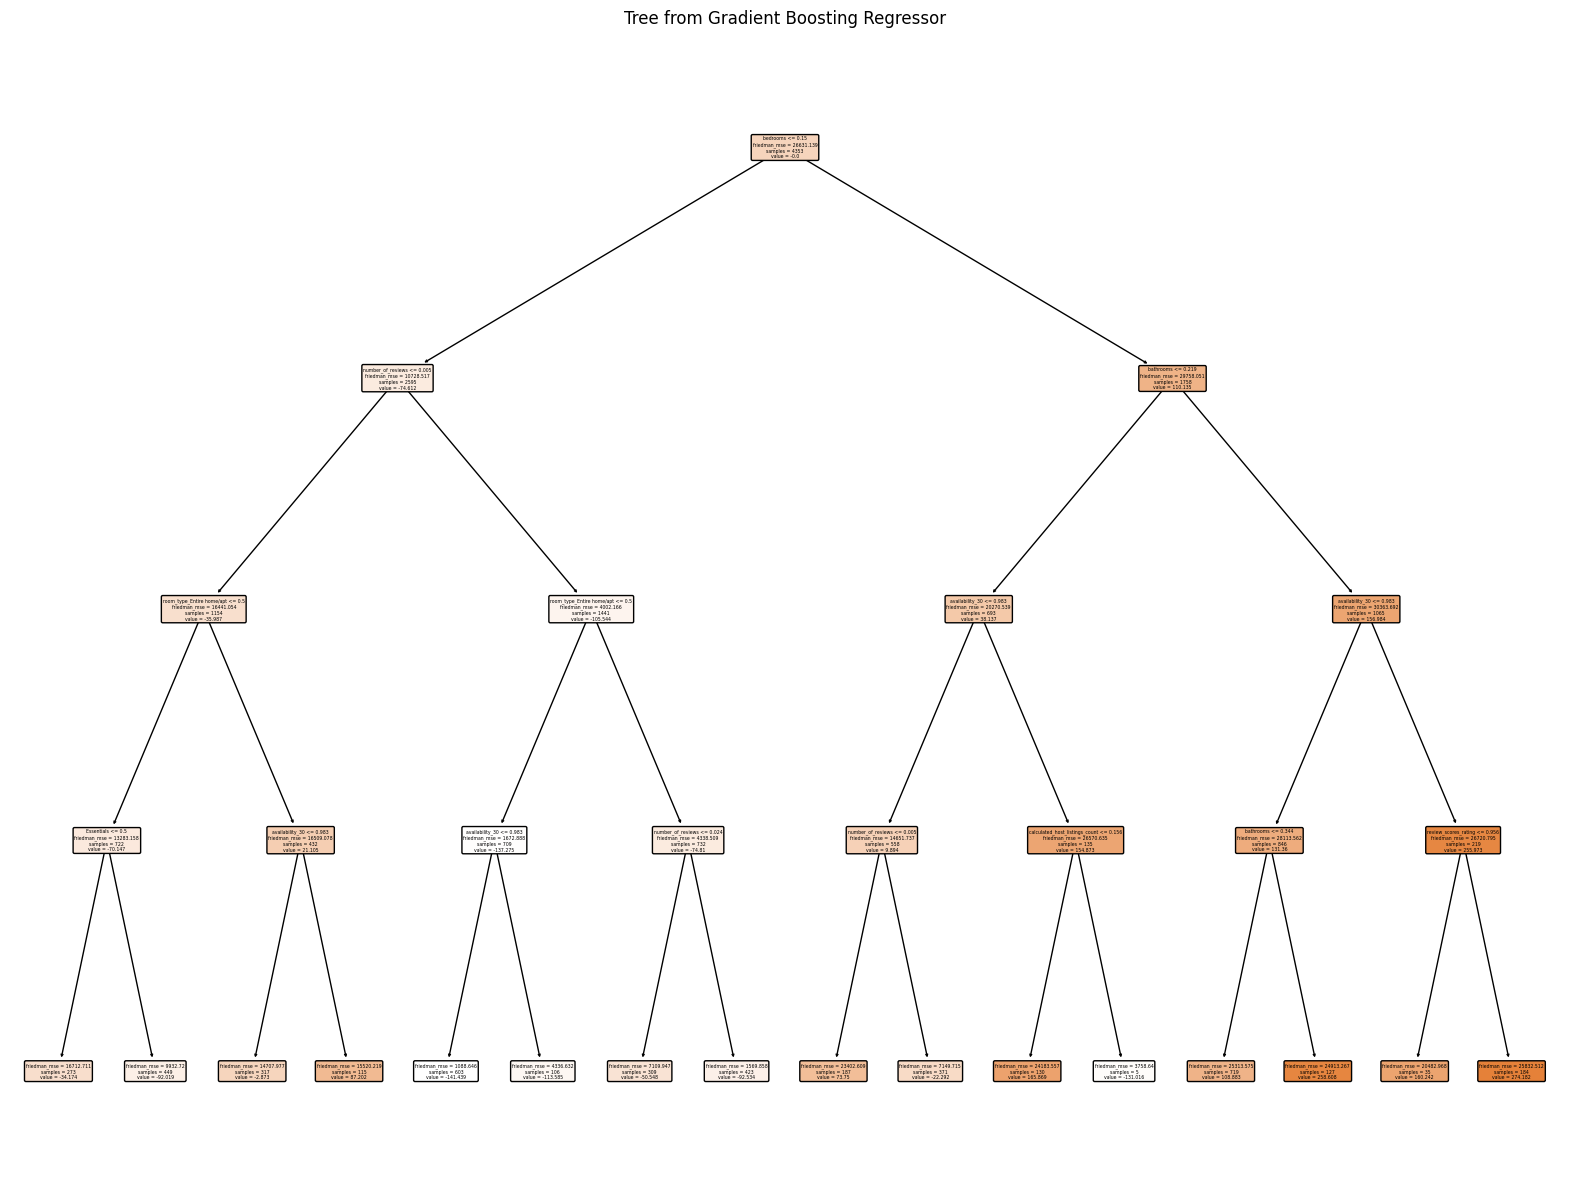

In [21]:
from sklearn.tree import plot_tree

best_gbr.fit(X_train, y_train)

# Access the first tree in the first stage of boosting
estimator = best_gbr.estimators_[0, 0]  # [0, 0] for the first stage of boosting and the first tree in that stage

# Plot the tree using plot_tree
plt.figure(figsize=(20,15))
plot_tree(estimator, filled=True, feature_names=X_train.columns, rounded=True)
plt.title("Tree from Gradient Boosting Regressor")
plt.show()